# <span style="color:green">Quant Platform</span>

The <span style="color:green">*Quant Platform*</span> is a framework for conducting backtests and analyzing the results that can be easily adapted for live trading. Some components needs to be modified or adapted for each strategy being backtested, others can be left alone.

### Overview of components for <span style="color:green">Quant Platform</span>

<span style="color:blue">Blue</span> components require little to no modification for each strategy tested, while <span style="color:orange">orange</span> components do require modification

1. <span style="color:orange">Data Processor</span>
    - Loads and merges data
    - Provides universe of securities and signals for each date
1. <span style="color:blue">Portfolio</span>
    - Tracks current portfolio and account balance sheet
    - Keeps records of all trades/transactions
    - Keeps history of NAV and margin requirements
1. <span style="color:orange">Trading Rule</span>
    - Decides which trades to make given a universe of securities, signals, and current portfolio
1. <span style="color:blue">Executor</span>
    - "Submits" order either hypothetically using historical data or live to a brokerage
    - Calculates or retrieves transaction prices accounting for any liquidity costs
1. <span style="color:blue">Statistician</span>
    - Looks at results of backtest or live trading and computes statistics ($\alpha$ etc) as well as informative plots (e.g. NAV and margin over time)

### Pseudo-code for backtest

At a high level, our backtest will:

1. Tell the **Data Processor** to load all the necessary data
1. For each unique date in the data:
    1. Get signal (book and market values of equity in this case) and price data for that date from the **Data Processor**
    1. Tell **Portfolio** to update prices based on new data
    1. Ask **Trading Rule** to decide which trades to make
    1. Tell **Executor** to execute the trades
    1. Update **Portfolio** to reflect the executed trades
1. Tell **Statistician** to summarize the results

In [59]:
# Imports
from IPython.display import display, Markdown, Latex, clear_output
import numpy as np
import pandas as pd

In [60]:
# Step 1: "Run" the notebooks containing definitions of the specifics of the data, strategy, and post-test statistics we want to compute
# Think about this as importing these tools but not using them yet

# These tools should be changed depending on the strategy you are testing
%run sbf_data_processor.ipynb
%run sbf_trading_rule.ipynb

# # These tools should remain unchanged across strategies unless you have a good reason to change them
%run portfolio_db.ipynb
%run backtest_executor.ipynb # if you were live trading a strategy, this would be replace by code that submitted orders etc

In [61]:
# Step 2: Create the tools we'll need to do the backtest
# These can be customized and changed while keeping the rest of this file (the backtest logic) the same

# DO edit this code to make sure that the specifics tools you want for this backtest are chosen here

# DO NOT edit the names of the variables, only what's assigned to them. So 
# good: data_processor = MyNewDataProcessor() 
# bad: my_new_data_processor = MyNewDataProcessor()

# Data processor, in charge of loading and doling out data
data_processor = SBFDataProcessor() 

In [62]:
# Portfolio database, keeps track of all the trades the backtest makes, the strategy NAV, and the current portfolio as we go through the backtest
%run portfolio_db.ipynb
portfolio_db = PortfolioDB()

# Strategy logic, in charge of choosing trades based on current portfolio and data
# This exact code would be used for live trading 
trading_rule = SBFTradingRule(portfolio_db)

# Trade executor, in charge of "executing" trades the strategy decides on, turning them into transactions and updating the portfolio
trade_executor = BacktestExecutor(portfolio_db)

# Info about the strategy, used for ex-post statistics and output not the actual backtest
strategy_info = {
    'brief descriptor': 'sbf_ew', 
    'plot descriptor': 'Long Bitcoin, Short Banks who Issue Stock, Equal-Weighted',
    'universe': 'Banking US Equities and Bitcoin',
    'signals': 'Banking Secondary Equity Issuances',
    'trading rule': 'Buy X% (currently 5) of NAV in Bitcoin when Bank issues stock, Short X% (currently 5) of Underlying Bank Stock',
    'holding period': 'Two months (can be altered in constants.py)',
    'periods per year': 252, 
    'time lag': '0', #We trade on the annoucement of the secondary equity issuance which should be immediate
    'output folder name': 'output'
}

# Statistician, used to tabulate and plot statistics after the backtest runs
%run backtest_statistician.ipynb
statistican = BacktestStatistican(portfolio_db,strategy_info)

'2024-02-29: 220.32140492902226 | 0.0'

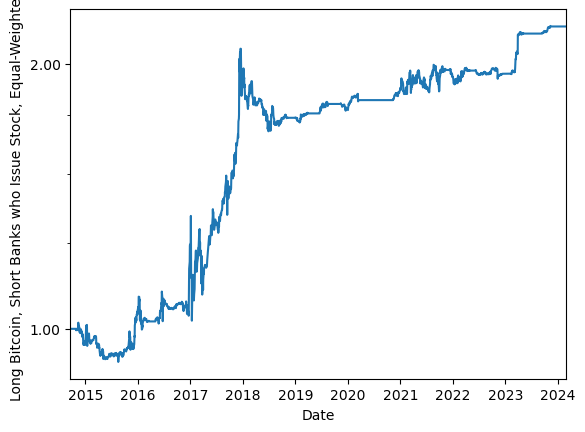

In [63]:
# Step 3: Run actual backtest
# Do NOT edit this cell without a very good reason

# Add 100 initial cash to our portfolios
portfolio_db.add_cash(100)

# Get our list of unique dates
udates = data_processor.unique_dates()

# Main loop for the backtest
for date in udates:
    # dataframes for the date
    signal_df = data_processor.signal_df_for_date(date)
    price_df = data_processor.price_df_for_date(date)

    # Update prices to reflect the new values after however much time has passed
    # Need to dot his first each date because the updated prices may affect our trading rule
    portfolio_db.update_prices(price_df)
    
    # Ask the trading rule what trades we should make
    open_trades_df, close_trades_df = trading_rule.compute_trades(signal_df=signal_df, date=date)

    # apply dates to trades
    open_trades_df['open_datetime'] = date
    close_trades_df['close_datetime'] = date

    # execute trades
    trade_executor.execute_opens(open_trades_df=open_trades_df, price_df=price_df)
    trade_executor.execute_closes(close_trades_df=close_trades_df, price_df=price_df)    
    
    # Record account data for today
    portfolio_db.record_account_data(price_df=price_df,datetime=date)
    
    # Do some fancy output tracking our NAV and margin requirement each day
    clear_output(wait=True)
    display( np.datetime_as_string(np.datetime64(date), unit='D') + ': ' + str(portfolio_db.current_nav()) + " | " + str(portfolio_db.current_margin()))

# Now that the loop is done, tell the statistican to output stats
statistican.output_stats()